In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd

In [2]:
# Enable the cache
ff1.Cache.enable_cache('cache') 

# Setup plotting
plotting.setup_mpl()

In [3]:
# Load the session data
quali = ff1.get_session(2021, 'Abu Dhabi', 'Q')

# Get the laps
laps = quali.load_laps(with_telemetry=True)

core           INFO 	Loading laps for Abu Dhabi Grand Prix - Qualifying [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['6', '44', '77', '33', '99', '5', '9', '55', '22', '31', '47', '14', '7', '63', '16', '4', '10', '18', '11', '3']


In [4]:
# Select the laps from Hamilton and Verstappen
laps_ver = laps.pick_driver('VER')
laps_ham = laps.pick_driver('HAM')

# Get the telemetry data from their fastest lap
fastest_ver = laps_ver.pick_fastest().get_telemetry().add_distance()
fastest_ham = laps_ham.pick_fastest().get_telemetry().add_distance()

# Since the telemetry data does not have a variable that indicates the driver, 
# we need to create that column
fastest_ver['Driver'] = 'VER'
fastest_ham['Driver'] = 'HAM'

# Merge both lap telemetries so we have everything in one DataFrame
telemetry = pd.concat([fastest_ver, fastest_ham])

In [5]:
# We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

In [6]:
# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [7]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [8]:
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

In [9]:
average_speed

,Minisector,Driver,Speed
0,1,HAM,260.615385
1,1,VER,260.461538
2,2,HAM,233.035714
3,2,VER,236.482759
4,3,HAM,219.600000
5,3,VER,216.766667
6,4,HAM,265.080000
7,4,VER,265.080000
8,5,HAM,279.173913
9,5,VER,279.869565


In [10]:
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

In [11]:
fastest_driver

,Minisector,Fastest_driver
0,1,HAM
3,2,VER
4,3,HAM
6,4,HAM
9,5,VER
11,6,VER
12,7,HAM
14,8,HAM
17,9,VER
19,10,VER


In [12]:
# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == 'VER', 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == 'HAM', 'Fastest_driver_int'] = 2

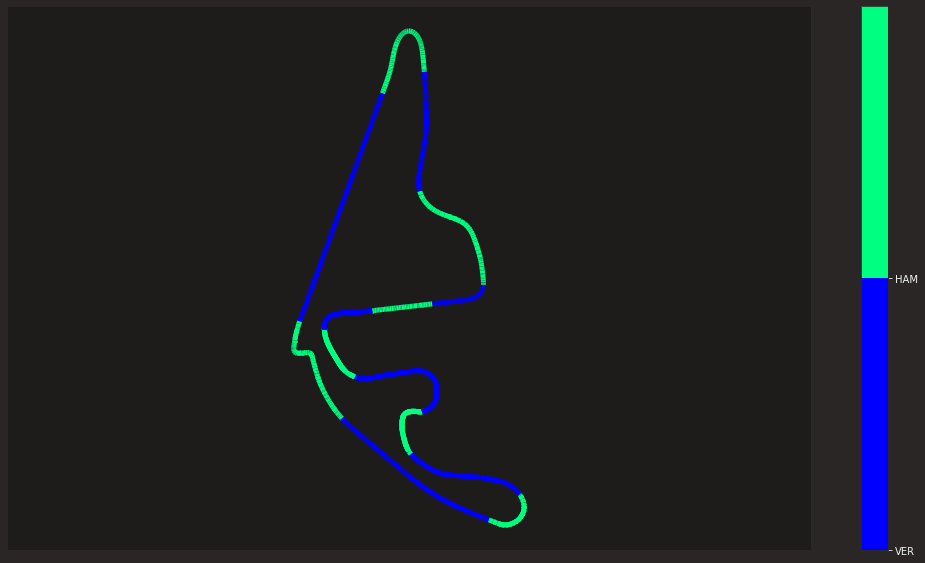

In [13]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

cmap = cm.get_cmap('winter', 2)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [18, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks([1, 2])
cbar.set_ticklabels(['VER', 'HAM'])

plt.savefig(f"2021_ver_ham_q.png", dpi=300)

plt.show()